In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn

# small library for generation of gridworld environments
from src.environments.gridworld import GridWorld, gridworld_from_map

# An Empirical Exploration of Provisional Temporal Difference Learning
___
PTD methods, in theory, provide an online method for off-policy policy evaluation with eligibility traces [[1](#ptd)]. These methods are theoretically more sound than other variants of TD$(\lambda)$, as they do not require traces to be cut once off-policy actions are taken, meaning that they never bootstrap when $\lambda = 1$. Here we provide an empirical analysis of these methods in a simple gridworld environment, comparing PTD with other off-policy algorithms, including Retrace$(\lambda)$[[2](#retrace)] and TD$(\lambda)$ with importance sampling [[3](#etop)].

## PTD $(\lambda)$

Monte Carlo methods for reinforcent learning employ samples of entire trajectories in order to estimate state values. In the case of off-policy learning, trajectories are weighted according to the ratio between the probability of the trajectory under the target policy, and that under the behaviour policy. TD($\lambda$) methods bridge between these Monte Carlo methods and bootstrapping methods, the latter of which approximate the value of a state using current estimates for the values of other states, rather than full returns. This is often implemented online through a mechanism known as _eligibility traces_. However, it has been historically impossible to apply eligibility traces to perform off-policy Monte Carlo online, as once an off policy action is taken, the probability of the trajectory decreases, reducing the weight of changes to values that have already been made. PTD$(\lambda)$ corrects for this, by maintaining a second _provisional_ trace, which tracks the history of changes made along the trajectory, and either partially undoes or amplifies these changes, according to the importance sampling ratios of later actions in the trajectory.

### Forward View
The forward view of PTD works as follows: following the work of Schwartz [[4](#ddc)], the discount factor, $\gamma$, is interpreted to represent the degree (or probability) to which an episode continues at every step (1 - $\gamma$ is then the degree to which the trajectory terminates). Similarly, the trace parameter, $1 - \lambda$, then represents the degree to which the value of a state reached is bootstrapped - this can only happen for the portion of the episode which did not terminate. As such, some fraction of each step terminates, some fraction is bootstrapped, and some fraction continues on. This gives us two TD errors between every state $k$ at every subsequent step $t$. One full backup for the fraction of the trajectory that terminates: 
$$\epsilon_k^t = \sum_{i=k+1}^t r_i - \theta^\top \phi(S_k)$$
and one bootstrapped backup for the fraction of the trajectory that does not, but is bootstrapped: 
$$\bar{\delta}_k^t = \sum_{i=k+1}^t r_i + \theta^\top \phi(S_t) - \theta^\top \phi(S_k)$$
each of these errors are weighted according to the fraction of the trajectory that reaches step $t$, according to the above weighting scheme, as well as the importance sampling ratios for the trajectory between steps $k$ and $t$

The authors then define the full forward TD error for the $k$th state, given data up to time $t$ as:
$$\delta_{k,t}^{\lambda\rho} = \rho_k \sum_{i=k+1}^{t-1}C_k^{i-1}\left[(1 - \gamma)\epsilon_k^i + \gamma(1-\lambda)\bar{\delta}_k^i\right] + \rho_k C_k^{t-1}\left[(1 - \gamma)\epsilon_k^t + \gamma\bar{\delta}_k^t\right]$$
with $$ C_k^t = \prod_{i=k+1}^{t-1}\gamma \lambda \rho_i$$

where $\rho_i$ denotes the importance sampling ratio at step $i$

These errors are used to derive a backward view, and further, the corresponding updates are shown to be equal to those of on policy TD$(\lambda)$ in expectation (though actual rollouts depend on the importance sampling ratios), showing that any backward view that corresponds to this forward view can indeed generate true Monte Carlo updates when $\lambda = 1$

### Backward View

The corresponding backward view for PTD$(\lambda)$ acheives _interim equivalence_ with the forward view, meaning that while parameter updates are assumed to occur offline (after the episode), updates are equal to those of the forward view at any horizon. The backward view is derived by noticing that an online update $\left(\theta^B\right)$ can be represented in terms of the forward updates $\left(\theta^F\right)$:
$$\Delta\theta^B_t = \sum_{k=0}^t \Delta \theta^F_{k,t+1} - \sum_{k=0}^{t-1} \Delta \theta^F_{k,t}$$
where $\theta^F_{k,t}$ denotes the forward updates to the state at time step $k$ using data up to step $t$, as described above. This gives rise to three update rules, which generate (online) updates with interim equivalence to the forward view above: the parameter update rule, expressed in terms of $\delta_t$, the standard one-step TD error at time $t$:
$$\Delta\theta^B_t = \alpha \delta_t e_t + (\rho_t - 1)u_t$$
the trace update rule:
$$e_t = \rho_t(\phi(S_t) + \gamma \lambda e_{t-1})$$
and the provisional weight update rule:
$$u_t = \gamma\lambda\left( \rho_{t-1}u_{t-1} + \alpha \bar{\delta}_{t-1}^t e_{t-1}\right)$$

Intuitively speaking, the parameter updates from early in the trajectory can be undone in an online manner if actions from later in the trajectory deviate from the target policy, since $(\rho_t - 1)$ will be negative, and $u$ effectively accumulates parameter weight changes along the trajectory. However, as will be demonstrated below, the provisional weights can also cause a destabilization in learning, as they can amplify previous changes, whenever importance sampling ratios are greater than 1. 


## Empirical Results

We examine PTD and related off-policy policy evaluation methods in a simple deterministic gridworld environment, with a fixed target policy, visualized below. Trajectories start at cell (5,5). States are coloured according to the reward received upon arrival in that state, and the target policy is represented by an arrow pointing in the direction of the action taken at that state. The behaviour policy is fixed, selecting from the available actions uniformly at random at every step. 

In [3]:
shp,isd,t_p,obs,f,term,rew = gridworld_from_map('./src/environments/gridworld_maps/spiral.map', 
                                            [1,0,0,0,0], tabular=True)
env = GridWorld(shp,isd,t_p,obs,f,term,rew,gamma=0.9)

(9, 11, 3) (9, 11, 99)
(9, 11, 100)


In [4]:
target_actions = np.loadtxt('./spiralpolicy_flat.txt')
target_policy = np.zeros((len(target_actions),4)) * 0.025
target_policy[range(len(target_actions)), target_actions.astype(int)] += 1
behaviour_policy = np.ones(target_policy.shape) * 0.25

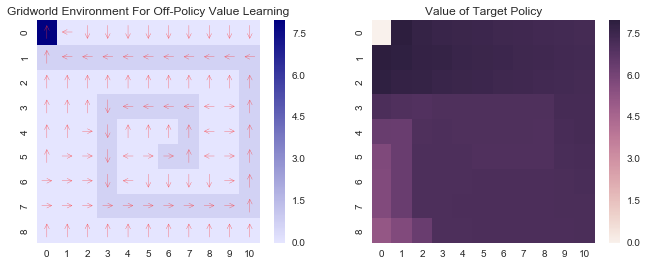

In [5]:
cmap = seaborn.light_palette("navy", as_cmap=True)
plt.figure(figsize=(11,4))
plt.subplot(121)
seaborn.heatmap(rew,  cmap=cmap)
arr_len = 0.7
action_map = [(0.5, -1 + (1-arr_len) / 2 ,0.5, 0 - (1-arr_len)/2), (0 + (1-arr_len)/2,-0.5,1 - (1-arr_len)/2,-0.5),(0.5,0- (1-arr_len)/2,0.5,-1 + (1-arr_len)/2), (1 - (1-arr_len)/2,-0.5,0 + (1-arr_len)/2,-0.5)]
Y,X = env.shape
for i,el in enumerate(target_actions):
    
    
    y,x = np.unravel_index(i, env.shape)
    y = Y-y
    dx,dy,dx_,dy_ = action_map[int(el)]
    plt.annotate('',  xytext=(x + dx,y + dy), xy=(x + dx_,y + dy_), arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color=(1,0.2,0.2)))
plt.title("Gridworld Environment For Off-Policy Value Learning")

plt.subplot(122)
v = np.zeros((env.shape[0] * env.shape[1]))
for i in range(1000):
    v_last = np.copy(v)
    for s in range(len(v)):
        ss = np.zeros(len(v))

        ss[s] = 1
        ss = np.concatenate([(s,), ss])
        vv = 0
        rr = 0
        if not env.termination_map.flatten()[s]:
            for p, s_, r, term in env.P[tuple(ss)][target_actions[s]]:
                if not env.termination_map.flatten()[int(s_[0])]:
                    vv += env.gamma * p * v_last[int(s_[0])]
                rr += r * p
            v[s] = rr + vv
seaborn.heatmap(v.reshape(env.shape))
plt.title("Value of Target Policy")
plt.show()

We learn the value of states under the target policy using standard dynamic programming policy evaluation methods (right image above)

In [6]:
%run ProvisionalTD.py

## WARNING: Executing the next cell will write files to './rl_logs/' and may take a long time to run

We compare the PTD($\lambda$) algorithm with importance sampled TD($\lambda$) which cuts eligibility traces, and Retrace($\lambda$), which simply clips the importance sampling ratio, such that it is always less than one. In order to evaluate the relative attributes of these algorithms, we train all three in the monte carlo ($\lambda = 1$) setting, with the same learning rate, over the same time period.

In [328]:
n_episodes = 4000
n_learners = 10
for i in range(n_learners):
    learn(behaviour_policy, target_policy, env, n_episodes=n_episodes, alpha=0.001, gamma=env.gamma)
for i in range(n_learners):
    learn_retrace(behaviour_policy, target_policy, env, n_episodes=n_episodes, alpha=0.001, gamma=env.gamma)
for i in range(n_learners):
    learn_is(behaviour_policy, target_policy, env, n_episodes=n_episodes, alpha=0.001, gamma=env.gamma)

setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 666
Completed Episode 1332
Completed Episode 1998
Completed Episode 2664
Completed Episode 3330
Completed Episode 3996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 666
Completed Episode 1332
Completed Episode 1998
Completed Episode 2664
Completed Episode 3330
Completed Episode 3996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 666
Completed Episode 1332
Completed Episode 1998
Completed Episode 2664
Completed Episode 3330
Completed Episode 3996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 666
Completed Episode 1332
Completed Episode 1998
Completed Episode 2664
Completed Episode 3330
Completed Episode 3996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 666
Completed Episode 1332
Completed Episode 1998
Completed Episode 2664
Completed Episode 3330
Completed Epi

In [11]:
n_episodes = 4000
n_learners = 10
avg_val_dists_is = np.zeros(n_episodes)
val_dists_is = []
for i in range(n_learners,2*n_learners):    
    a = [((v - v_)**2).mean() for v_ in np.loadtxt('./rl_logs/experiment_{}/value.csv'.format(i), delimiter=",")]
    val_dists_is.append(a)
    avg_val_dists_is += np.array(a) / n_learners
avg_val_dists_rt = np.zeros(n_episodes)
val_dists_rt = []
for i in range(2*n_learners, 3*n_learners):    
    a = [((v - v_)**2).mean() for v_ in np.loadtxt('./rl_logs/experiment_{}/value.csv'.format(i), delimiter=",")]
    val_dists_rt.append(a)
    avg_val_dists_rt += np.array(a) / n_learners
avg_val_dists = np.zeros(n_episodes)
val_dists = []
for i in range(3*n_learners, 4*n_learners):    
    a = [((v - v_)**2).mean() for v_ in np.loadtxt('./rl_logs/experiment_{}/value.csv'.format(i), delimiter=",")]
    val_dists.append(a)
    avg_val_dists += np.array(a) / n_learners

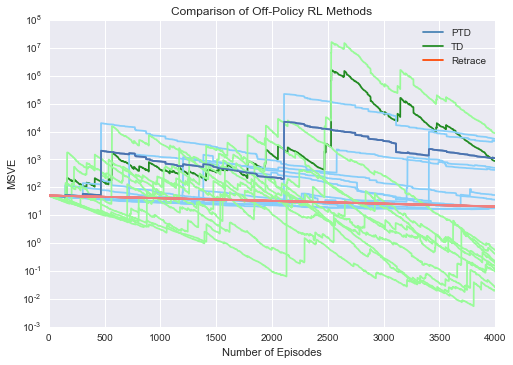

In [12]:
plt.semilogy(avg_val_dists,  color='steelblue')
plt.semilogy(avg_val_dists_is,  color='forestgreen') 
plt.semilogy(avg_val_dists_rt,  color='orangered') 
for i in val_dists:
    plt.semilogy(i, color='lightskyblue')
for i in val_dists_is:
    plt.semilogy(i, color='palegreen')
plt.plot(avg_val_dists) 

for i in val_dists_rt:
    plt.plot(i, color='lightcoral')
plt.title('Comparison of Off-Policy RL Methods')
plt.xlabel('Number of Episodes')
plt.ylabel('MSVE')
plt.legend(['PTD', 'TD', 'Retrace'])
plt.show()

We note that each algorithm has slightly different attributes, training under the same conditions. Importance Sampled TD (green) clearly achieves the best MSVE of all the algorithms, but is also the most unstable, with weights reaching order of magnitude further than those of PTD (blue). PTD is somewhat more stable, but does not reach good parameter values as quickly as Importance Sampled TD does most of the time. Retrace (red) is clearly the most stable, though, at this learning rate it seems to hardly learn at all. We examine Retrace at a faster learning rate below, and perform further analysis of PTD after that. While the effects of the experiments observed here may be implementation, environment, or policy specific, we note that PTD is highly unstable. This is because when importance sampling ratios are greater than 1, all of the previous updates along the trajectory are repeated, but amplified by the importance sampling ratio. However, performing retrace-style clipping of the importance sampling ratio does not create an unbiased learner, nor does direct clipping of the update magnitude - both still require very small learning rates in order to converge to good values.

In [10]:
for i in range(n_learners):
    learn_retrace(behaviour_policy, target_policy, env, n_episodes=n_episodes, alpha=0.01, gamma=env.gamma)

setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 666
Completed Episode 1332
Completed Episode 1998
Completed Episode 2664
Completed Episode 3330
Completed Episode 3996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 666
Completed Episode 1332
Completed Episode 1998
Completed Episode 2664
Completed Episode 3330
Completed Episode 3996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 666
Completed Episode 1332
Completed Episode 1998
Completed Episode 2664
Completed Episode 3330
Completed Episode 3996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 666
Completed Episode 1332
Completed Episode 1998
Completed Episode 2664
Completed Episode 3330
Completed Episode 3996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 666
Completed Episode 1332
Completed Episode 1998
Completed Episode 2664
Completed Episode 3330
Completed Epi

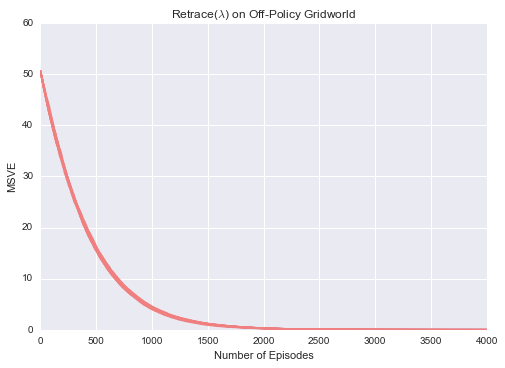

In [18]:
avg_val_dists_rt = np.zeros(n_episodes)
val_dists_rt = []
for i in range(n_learners):    
    a = [((v - v_)**2).mean() for v_ in np.loadtxt('./rl_logs/experiment_{}/value.csv'.format(i), delimiter=",")]
    val_dists_rt.append(a)
    avg_val_dists_rt += np.array(a) / n_learners
plt.plot(avg_val_dists_rt,  color='blue') 
for i in val_dists_rt:
    plt.plot(i, color='lightcoral')
plt.title('Retrace($\lambda$) on Off-Policy Gridworld')
plt.xlabel('Number of Episodes')
plt.ylabel('MSVE')
plt.show()


We see that Retrace is stable enough in this environment to converge to good values under a much higher learning rate ($\alpha = 0.01$) than the other algorithms. 

In order to examine the effectiveness of PTD under more stable conditions, we clip the magnitude of the TD update to 0.1. We examine the convergence of this algorithm under several different learning rates, noting that the values converged to are better for lower learning rates, and non-optimal at higher learning rates. However, considering the simplicity of the environment, PTD is highly unstable, needing incredibly slow learning in order to converge to good values. We note that experiments were performed with clipping importance sampling ratios in PTD to 1, but this still did not converge to good value estimates without a slow learning rate.

In [27]:
n_episodes = 10000
for i in range(n_learners):
    learn_p_rate_limited(behaviour_policy, target_policy, env, n_episodes=n_episodes, alpha=0.0001, gamma=env.gamma)
for i in range(n_learners):
    learn_p_rate_limited(behaviour_policy, target_policy, env, n_episodes=n_episodes, alpha=0.001, gamma=env.gamma)

setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 1666
Completed Episode 3332
Completed Episode 4998
Completed Episode 6664
Completed Episode 8330
Completed Episode 9996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 1666
Completed Episode 3332
Completed Episode 4998
Completed Episode 6664
Completed Episode 8330
Completed Episode 9996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 1666
Completed Episode 3332
Completed Episode 4998
Completed Episode 6664
Completed Episode 8330
Completed Episode 9996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 1666
Completed Episode 3332
Completed Episode 4998
Completed Episode 6664
Completed Episode 8330
Completed Episode 9996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 1666
Completed Episode 3332
Completed Episode 4998
Completed Episode 6664
Completed Episode 8330
Complete

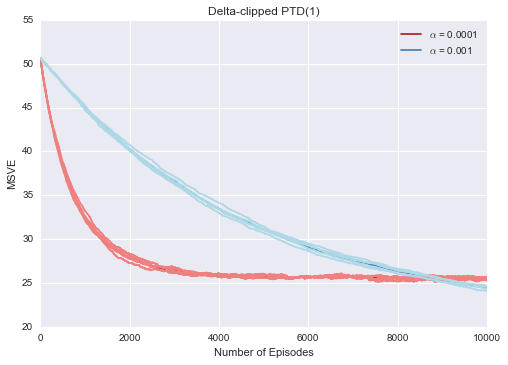

In [30]:
val_dists = []
avg_val_dists = np.zeros(n_episodes)
val_dists_2 = []
avg_val_dists_2 = np.zeros(n_episodes)

for i in range(n_learners):    
    a = [((v - v_)**2).mean() for v_ in np.loadtxt('./rl_logs/experiment_{}/value.csv'.format(i), delimiter=",")]
    val_dists.append(a)
    avg_val_dists += np.array(a) / n_learners
for i in range(n_learners,2*n_learners):    
    a = [((v - v_)**2).mean() for v_ in np.loadtxt('./rl_logs/experiment_{}/value.csv'.format(i), delimiter=",")]
    val_dists_2.append(a)
    avg_val_dists_2 += np.array(a) / n_learners
    
plt.plot(avg_val_dists,  color='firebrick') 
plt.plot(avg_val_dists_2,  color='steelblue') 

for i in val_dists:
    plt.plot(i, color='lightcoral')
for i in val_dists_2:
    plt.plot(i, color='lightblue')
plt.title('Delta-clipped PTD(1)')
plt.xlabel('Number of Episodes')
plt.ylabel('MSVE')
plt.legend([r'$\alpha$ = 0.0001', r'$\alpha$ = 0.001'])
plt.show()

In [20]:
n_episodes = 400000
n_learners = 2
avg_val_dists_rl = np.zeros(n_episodes)
val_dists_rl = []
for i in range(n_learners):
    learn_p_rate_limited(behaviour_policy, target_policy, env, n_episodes=n_episodes, alpha=0.000001, gamma=env.gamma)

setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 66666
Completed Episode 133332
Completed Episode 199998
Completed Episode 266664
Completed Episode 333330
Completed Episode 399996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 66666
Completed Episode 133332
Completed Episode 199998
Completed Episode 266664
Completed Episode 333330
Completed Episode 399996


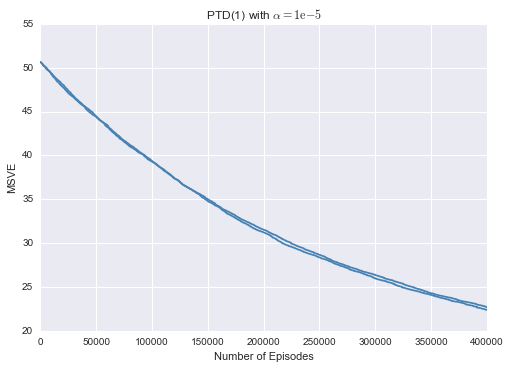

In [31]:
val_dists = [((v - v_)**2).mean() for v_ in np.loadtxt('./rl_logs/experiment_11/value.csv', delimiter=",")]
plt.plot(val_dists,  color='steelblue')
val_dists = [((v - v_)**2).mean() for v_ in np.loadtxt('./rl_logs/experiment_12/value.csv', delimiter=",")]
plt.plot(val_dists,  color='steelblue')
plt.title(r'PTD(1) with $\alpha = 1\mathrm{e}{-5}$')
plt.xlabel('Number of Episodes')
plt.ylabel('MSVE')
plt.show()

Clearly, PTD suffers from stability issues in this particular environment when $\lambda = 1$. However, we note that with smaller values of $\lambda$, the additional bias goes a long way towards stabilizing learning.

In [100]:
n_episodes = 2000
n_learners = 5
for i in range(n_learners):
    learn(behaviour_policy, target_policy, env, n_episodes=n_episodes, alpha=0.01, gamma=env.gamma, lamb=0.2)
for i in range(n_learners):
    learn_retrace(behaviour_policy, target_policy, env, n_episodes=n_episodes, alpha=0.01, gamma=env.gamma, lamb=0.2)
for i in range(n_learners):
    learn(behaviour_policy, target_policy, env, n_episodes=n_episodes, alpha=0.01, gamma=env.gamma, lamb=0.4)
for i in range(n_learners):
    learn_retrace(behaviour_policy, target_policy, env, n_episodes=n_episodes, alpha=0.01, gamma=env.gamma, lamb=0.4)
for i in range(n_learners):
    learn(behaviour_policy, target_policy, env, n_episodes=n_episodes, alpha=0.01, gamma=env.gamma, lamb=0.6)
for i in range(n_learners):
    learn_retrace(behaviour_policy, target_policy, env, n_episodes=n_episodes, alpha=0.01, gamma=env.gamma, lamb=0.6)
    

setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 666
Completed Episode 1332
Completed Episode 1998
Completed Episode 2664
Completed Episode 3330
Completed Episode 3996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 666
Completed Episode 1332
Completed Episode 1998
Completed Episode 2664
Completed Episode 3330
Completed Episode 3996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 666
Completed Episode 1332
Completed Episode 1998
Completed Episode 2664
Completed Episode 3330
Completed Episode 3996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 666
Completed Episode 1332
Completed Episode 1998
Completed Episode 2664
Completed Episode 3330
Completed Episode 3996
setting up
writing to ./rl_logs/experiment_0
Completed Episode 0
Completed Episode 666
Completed Episode 1332
Completed Episode 1998
Completed Episode 2664
Completed Episode 3330
Completed Epi

In [101]:
val_dists = np.zeros((6,n_learners,n_episodes))
avg_val_dists = np.zeros((6,n_episodes))

for j in range(6):
    for i in range(n_learners * j, n_learners * (j+1)): 
        a = [((v - v_)**2).mean() for v_ in np.loadtxt('./rl_logs/experiment_{}/value.csv'.format(i), delimiter=",")]
        val_dists[j][i % n_learners] = a
        avg_val_dists[j] += np.array(a) / n_learners

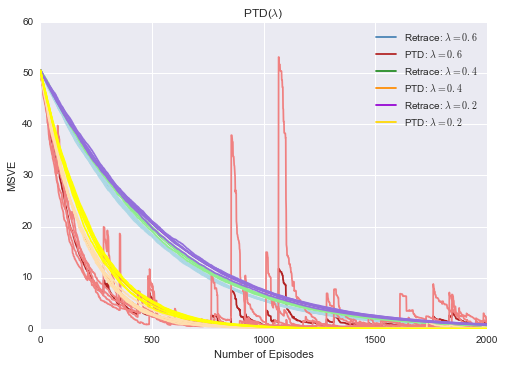

In [103]:
avg_colours = ['steelblue', 'firebrick',  'forestgreen', 'darkorange', 'darkviolet', 'gold']
line_colours = ['lightblue', 'lightcoral', 'lightgreen',  'navajowhite', 'mediumpurple', 'yellow' ]
for j in range(6):
    plt.plot(avg_val_dists[j][:2000],  color=avg_colours[j]) 
    pass

for j in range(6):
    for i in val_dists[j]:
        plt.plot(i[:2000], color=line_colours[j])

plt.title(r'PTD($\lambda$)')
plt.xlabel('Number of Episodes')
plt.ylabel('MSVE')
plt.legend([r'Retrace: $\lambda = 0.6$', r'PTD: $\lambda = 0.6$', r'Retrace: $\lambda = 0.4$', r'PTD: $\lambda = 0.4$', r'Retrace: $\lambda = 0.2$', r'PTD: $\lambda = 0.2$' ])
plt.show()

We can see that with low enough $\lambda$, PTD actually outperforms Retrace, learning as stably, but faster for the fixed l

We conclude that while PTD has nice theoretical properties, especially with $\lambda = 1$, in practice it can be unstable due to the fact that previous changes to the state can be amplified when the importance sampling ratios are greater than one. However, with intermediate values of lambda, these effects are reduced, leading to effective learning.

## References

[<a id='ptd' href="http://proceedings.mlr.press/v32/sutton14.pdf">1</a>]
Sutton, Richard S., et al. "A new Q (lambda) with interim forward view and Monte Carlo equivalence." _ICML_. 2014.

[<a id='retrace' href="https://arxiv.org/pdf/1606.02647.pdf">2</a>]
Munos, Rémi, et al. "Safe and efficient off-policy reinforcement learning." Advances in Neural Information Processing Systems. 2016.

[<a id='etop' href="http://scholarworks.umass.edu/cgi/viewcontent.cgi?article=1079&context=cs_faculty_pubs">3</a>]
Precup, Doina. "Eligibility traces for off-policy policy evaluation." Computer Science Department Faculty Publication Series (2000): 80.

[<a id='ddc' href="http://ieeexplore.ieee.org/abstract/document/917668/">4</a>]
Shwartz, Adam. "Death and discounting." _IEEE Transactions on Automatic Control_ 46.4 (2001): 644-647.